In [46]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
from sklearn.decomposition import PCA

def apply_pca(train_data, test_data, variance_threshold=0.95):
    pca_models = {}
    train_pca_data = {}
    test_pca_data = {}
    
    for strategy in train_data.keys():
        X_train = train_data[strategy].drop(columns=['Sharpe_Ratio_30']).values
        X_test = test_data[strategy].drop(columns=['Sharpe_Ratio_30']).values
        
        pca = PCA(n_components=variance_threshold, random_state=42)
        
        X_train_pca = pca.fit_transform(X_train)
        
        X_test_pca = pca.transform(X_test)
        
        train_pca_df = pd.DataFrame(X_train_pca, index=train_data[strategy].index)
        test_pca_df = pd.DataFrame(X_test_pca, index=test_data[strategy].index)
        
        train_pca_df['Sharpe_Ratio_30'] = train_data[strategy]['Sharpe_Ratio_30'].values
        test_pca_df['Sharpe_Ratio_30'] = test_data[strategy]['Sharpe_Ratio_30'].values
        
        train_pca_data[strategy] = train_pca_df
        test_pca_data[strategy] = test_pca_df
        pca_models[strategy] = pca
        
    return train_pca_data, test_pca_data, pca_models

In [48]:
market_features = pd.read_csv('all_features_BTCUSDT.csv', index_col=0, parse_dates=[0], low_memory=False)
market_features = market_features.resample('D').ffill()

strategies_data = {}
returns_features_path = 'returns_features'
for file in os.listdir(returns_features_path):
    if file.endswith('_returns_features.csv'):
        strategy_name = file.replace('_returns_features.csv', '')
        df = pd.read_csv(os.path.join(returns_features_path, file), index_col=0, parse_dates=[0], low_memory=False)
        df_selected = df[['ACF_Lag_1_10', 'ACF_Lag_1_30', 'Sharpe_Ratio_30']]
        df_selected = df_selected.resample('D').ffill()
        strategies_data[strategy_name] = df_selected




merged_data = {}
for strategy, df in strategies_data.items():
    merged_df = pd.merge(market_features, df, left_index=True, right_index=True, how='inner')
    merged_df = merged_df.dropna(axis=1, thresh=0.5 * len(merged_df))
    merged_df = merged_df.dropna()
    merged_data[strategy] = merged_df


In [49]:
def split_train_test(merged_data, test_size=0.3):
    train_data = {}
    test_data = {}
    for strategy, df in merged_data.items():
        df = df.sort_index()
        
        split_point = int(len(df) * (1 - test_size))
        
        train_df = df.iloc[:split_point]
        test_df = df.iloc[split_point:]
        
        train_data[strategy] = train_df
        test_data[strategy] = test_df
    return train_data, test_data

In [50]:
scaler = StandardScaler()
train_data, test_data = split_train_test(merged_data)
#train_data, test_data, pca_models = apply_pca(train_data, test_data, variance_threshold=0.99)

for strategy, df in train_data.items():
    features = df.drop(columns=['Sharpe_Ratio_30'])
    sharpe = df['Sharpe_Ratio_30']
    
    scaled_features = scaler.fit_transform(features)
    
    scaled_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
    
    scaled_df['Sharpe_Ratio_30'] = sharpe
    train_data[strategy] = scaled_df

    test_features = test_data[strategy].drop(columns=['Sharpe_Ratio_30'])
    test_sharpe = test_data[strategy]['Sharpe_Ratio_30']
    
    scaled_features_test = scaler.transform(test_features)
    
    scaled_df_test = pd.DataFrame(scaled_features_test, index=test_features.index, columns=test_features.columns)
    
    scaled_df_test['Sharpe_Ratio_30'] = test_sharpe
    test_data[strategy] = scaled_df_test

### K means

In [51]:
num_clusters = 3

for strategy, df in train_data.items():
    X = df.drop(columns=['Sharpe_Ratio_30'])
        
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(X)
    cluster_labels_test = kmeans.predict(test_data[strategy].drop(columns=['Sharpe_Ratio_30']))

    train_data[strategy]['Regime'] = cluster_labels
    test_data[strategy]['Regime'] = cluster_labels_test

In [52]:
#cluster names
for strategy, df in train_data.items():
    cluster_sharpe = df.groupby('Regime')['Sharpe_Ratio_30'].mean()
    
    sorted_clusters = cluster_sharpe.sort_values().index.tolist()
    
    regime_labels = ['Low', 'Normal', 'High'] 
    regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters, regime_labels)}
    
    df['Regime_Label'] = df['Regime'].map(regime_mapping)
    
    train_data[strategy] = df
    test_data[strategy]['Regime_Label'] = test_data[strategy]['Regime'].map(regime_mapping)

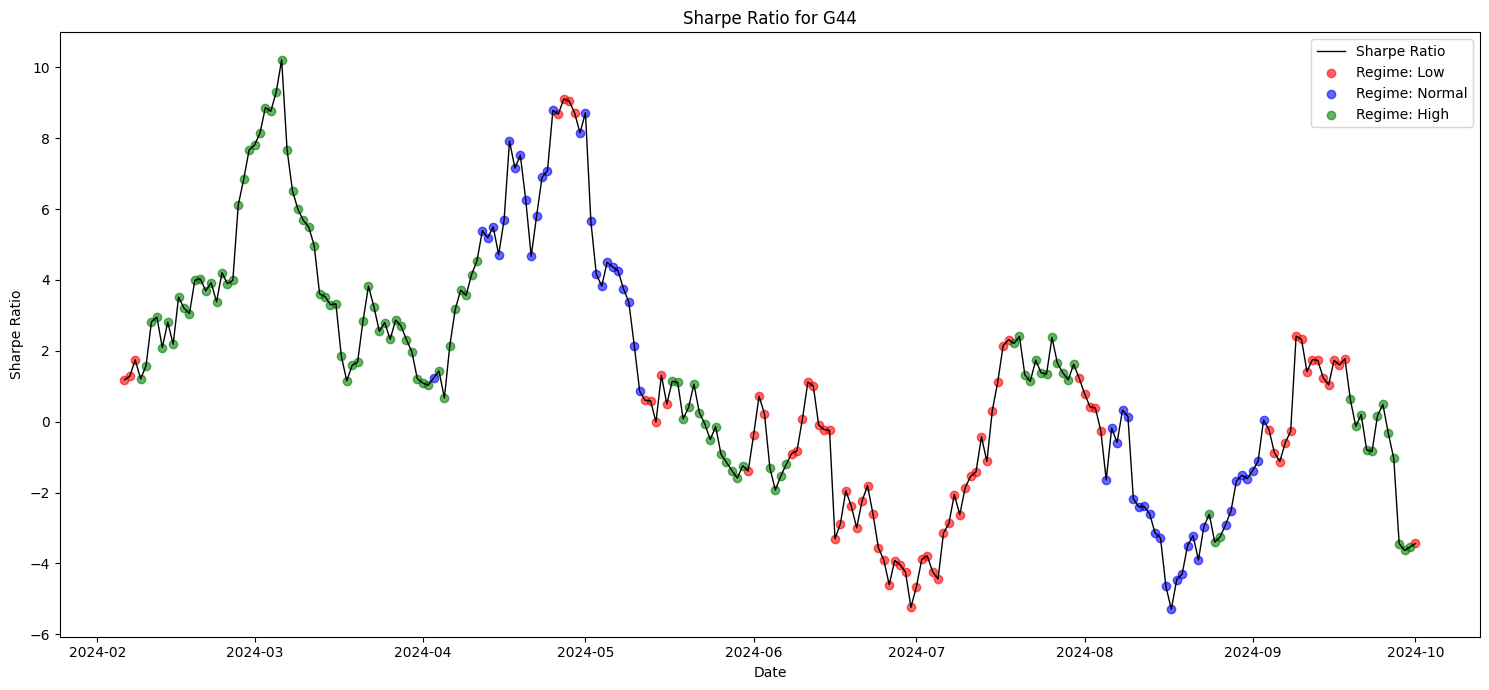

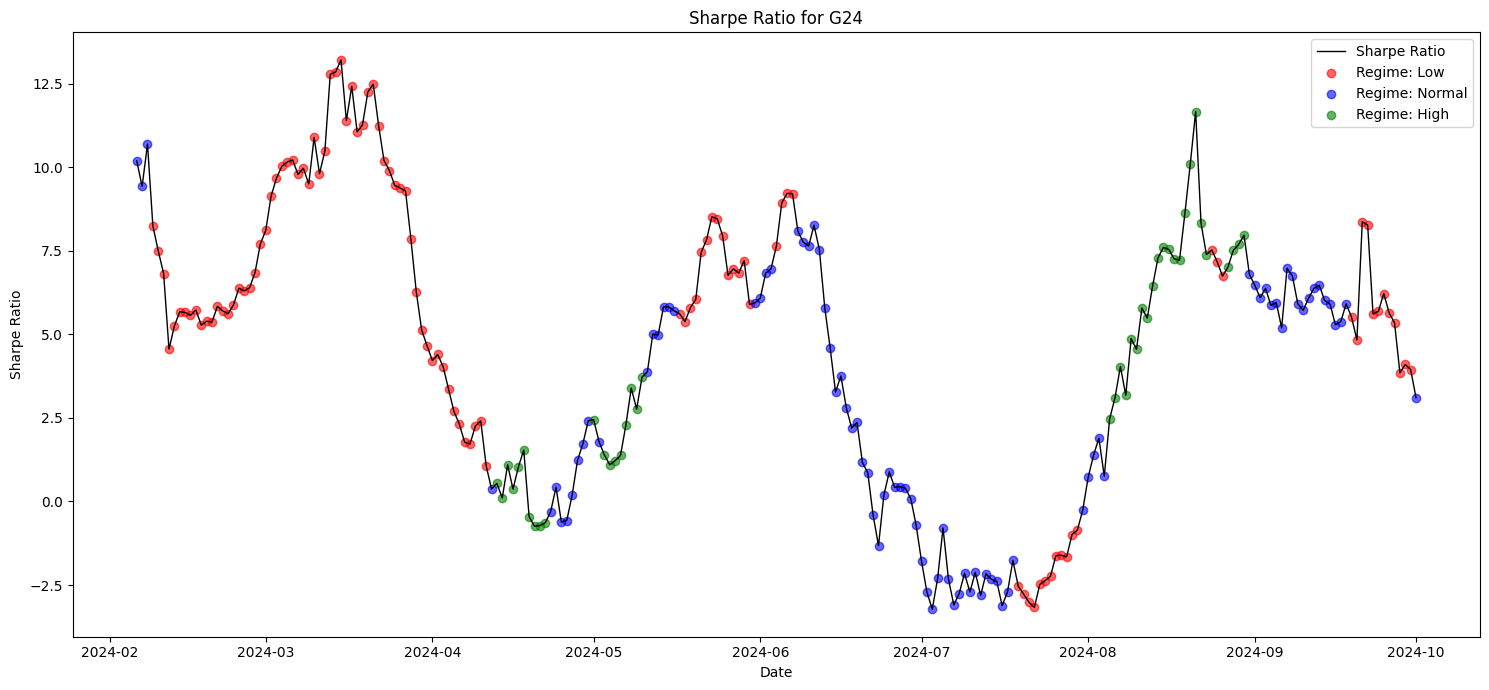

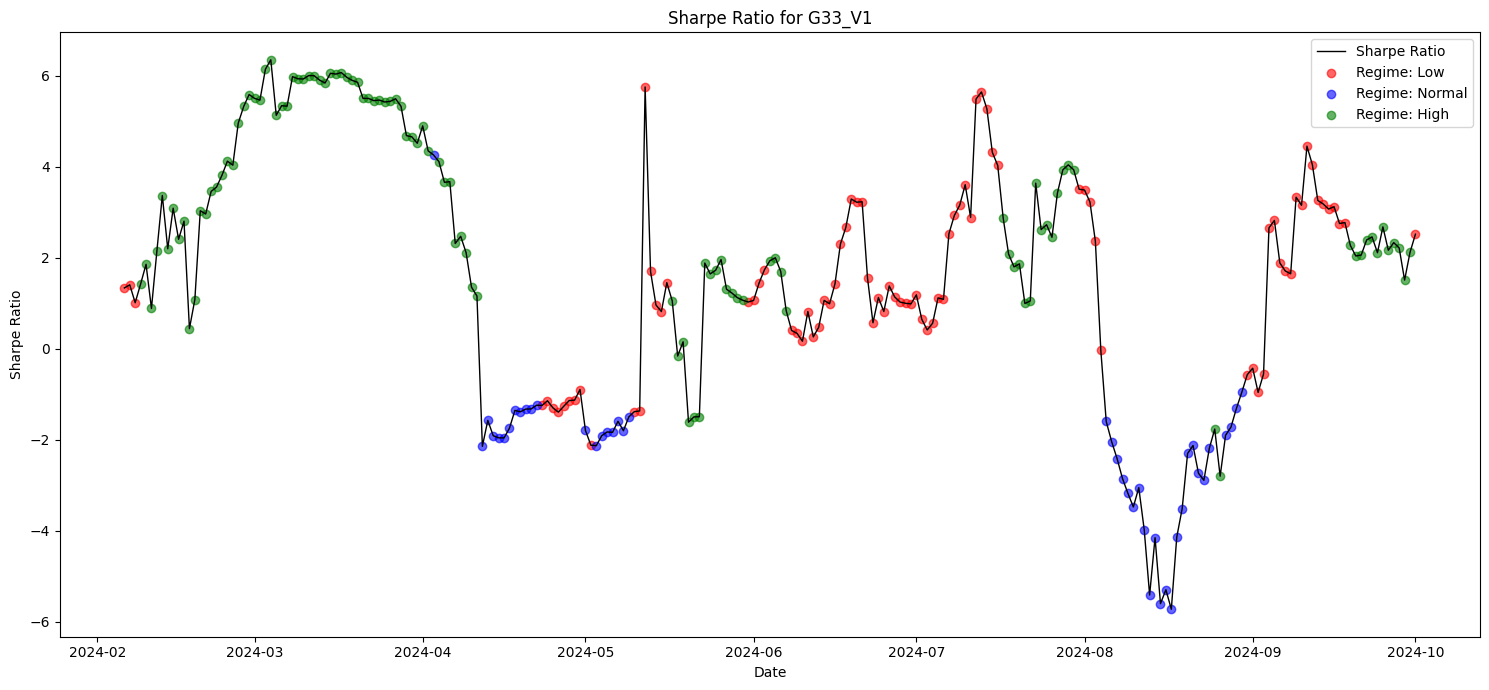

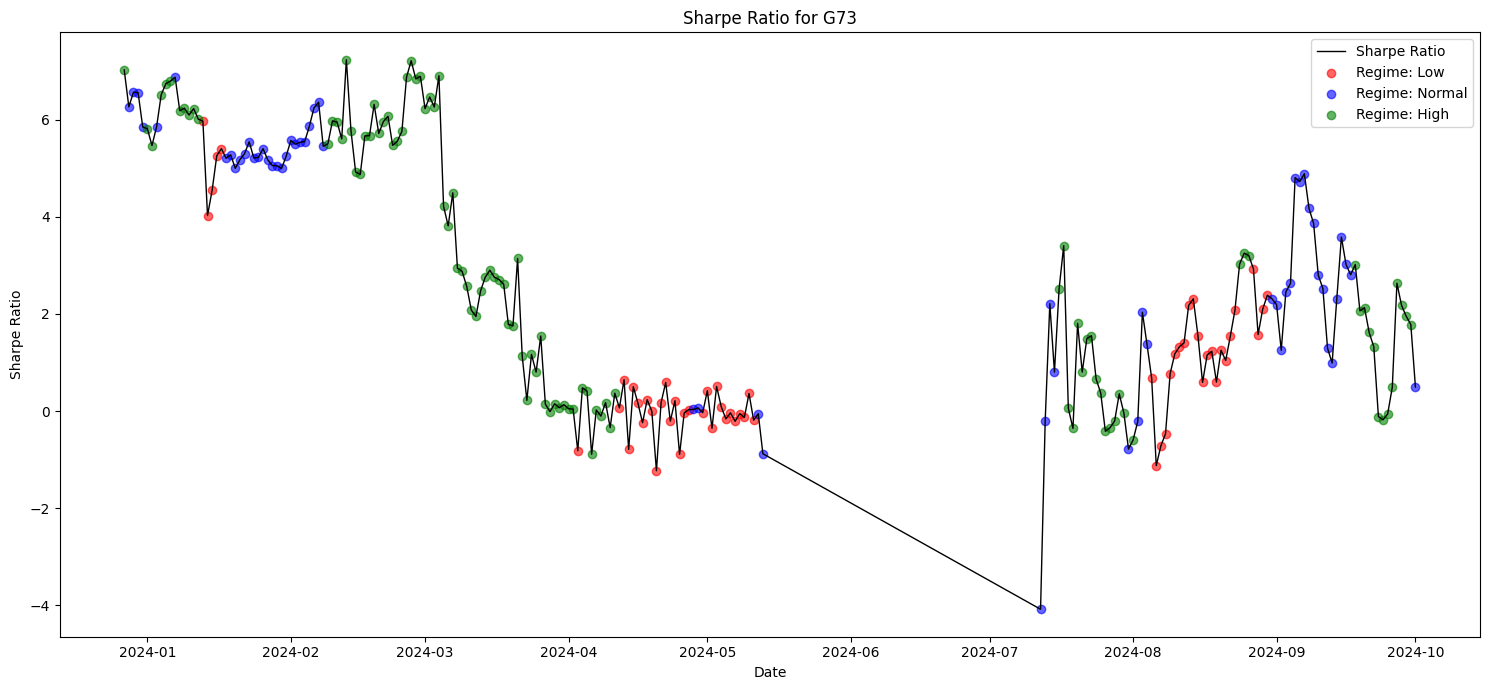

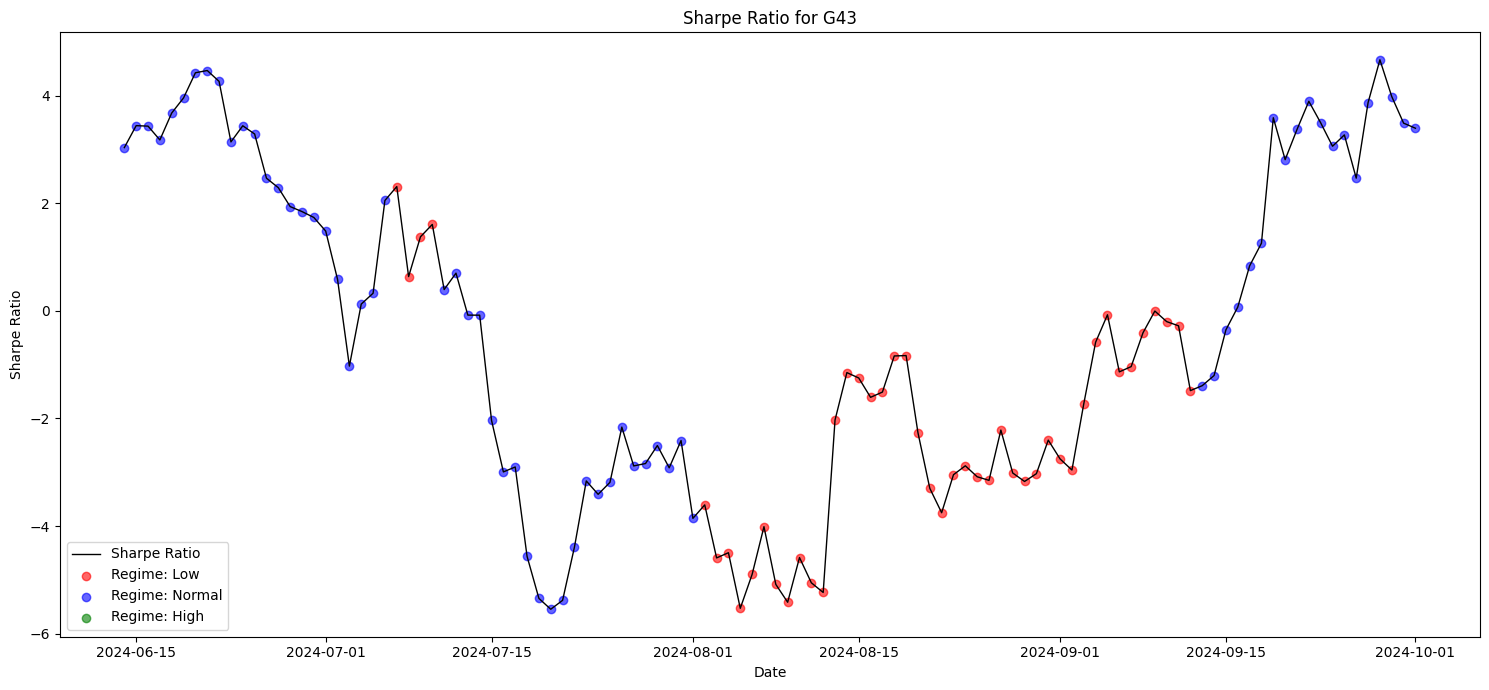

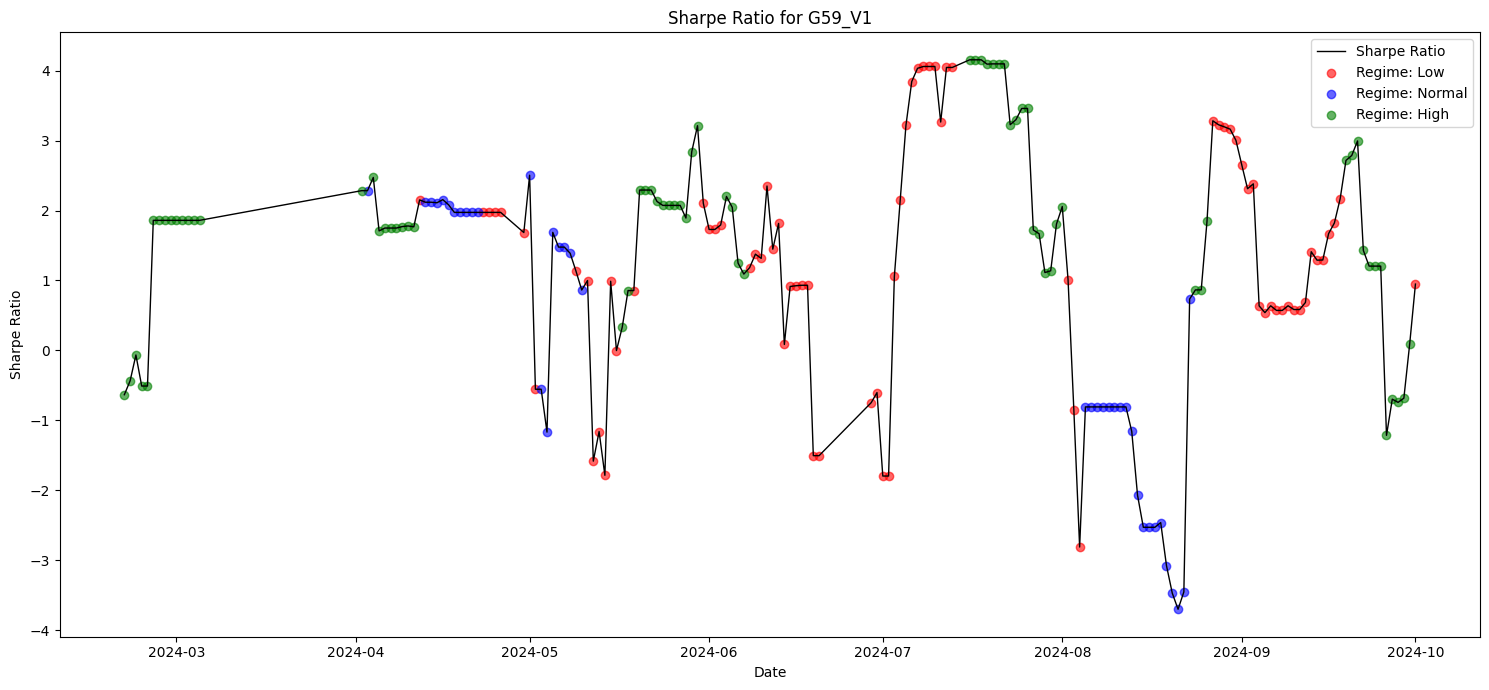

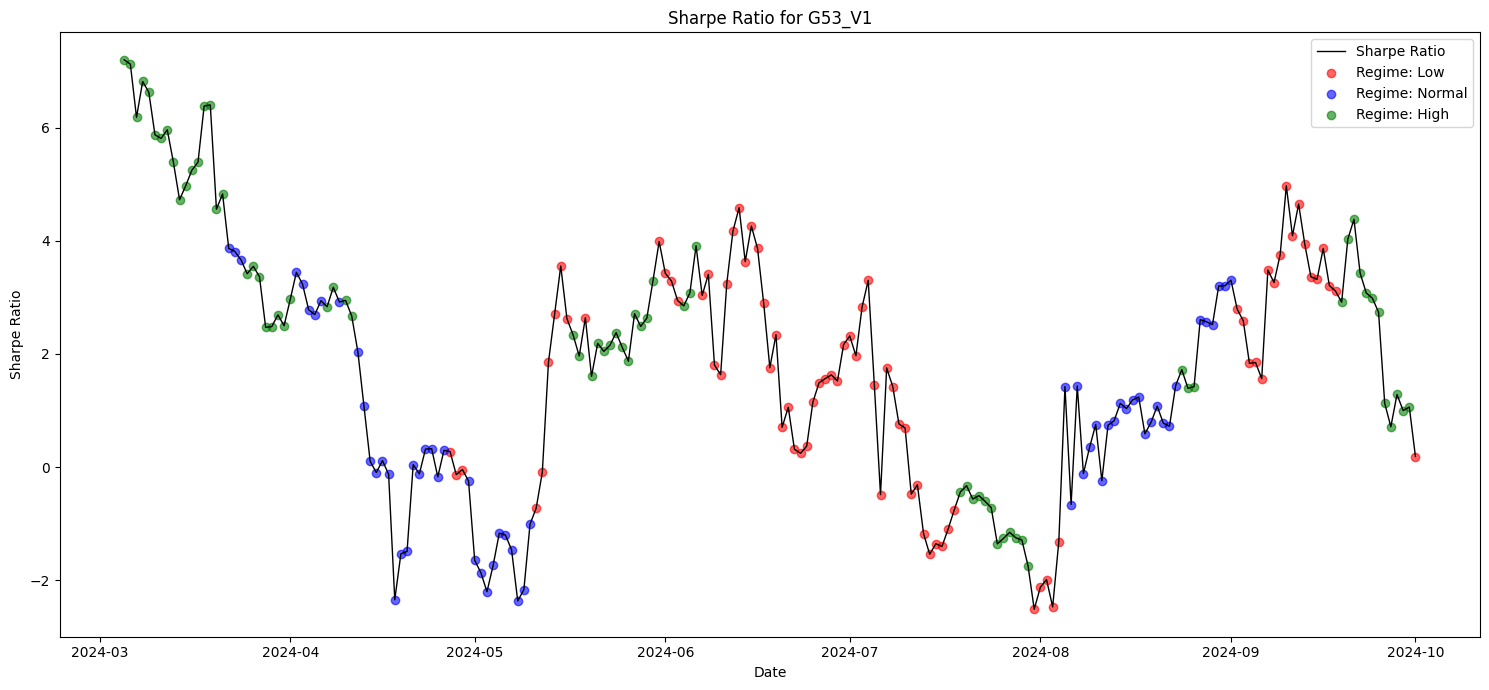

In [53]:
for strategy, df in test_data.items():
    plt.figure(figsize=(15,7))
    plt.plot(df.index, df['Sharpe_Ratio_30'], label='Sharpe Ratio', color='black', linewidth=1)
    
    colors = {'Low': 'red', 'Normal': 'blue', 'High': 'green'}
    
    for regime, color in colors.items():
        regime_data = df[df['Regime_Label'] == regime]
        plt.scatter(regime_data.index, regime_data['Sharpe_Ratio_30'], 
                    color=color, label=f'Regime: {regime}', alpha=0.6)
    
    plt.title(f'Sharpe Ratio for {strategy}')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"clustering_models/kmeans/{strategy}.png")
    plt.show()


### DBSCAN

In [54]:
scaler = StandardScaler()
train_data, test_data = split_train_test(merged_data)
train_data, test_data, pca_models = apply_pca(train_data, test_data, variance_threshold=0.99)


for strategy, df in train_data.items():
    
    features = df.drop(columns=['Sharpe_Ratio_30'])
    sharpe = df['Sharpe_Ratio_30']
    
    scaled_features = scaler.fit_transform(features)
    
    scaled_df = pd.DataFrame(scaled_features, index=features.index, columns=features.columns)
    
    scaled_df['Sharpe_Ratio_30'] = sharpe
    train_data[strategy] = scaled_df

    test_features = test_data[strategy].drop(columns=['Sharpe_Ratio_30'])
    test_sharpe = test_data[strategy]['Sharpe_Ratio_30']
    
    scaled_features_test = scaler.transform(test_features)
    
    scaled_df_test = pd.DataFrame(scaled_features_test, index=test_features.index, columns=test_features.columns)
    
    scaled_df_test['Sharpe_Ratio_30'] = test_sharpe
    test_data[strategy] = scaled_df_test

In [55]:
from sklearn.metrics import silhouette_score

def find_optimal_dbscan_parameters(strategy, df_train, eps_values, min_samples_values):
    X_train = df_train.drop(columns=['Sharpe_Ratio_30']).values
    best_score = -1
    best_params = {'eps': None, 'min_samples': None}
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_train)
            # Silhouette score requires at least 2 clusters
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters < 2:
                continue
            score = silhouette_score(X_train, labels)
            if score > best_score:
                best_score = score
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples
    
    return best_params, best_score

eps_options = np.arange(0.1, 1.0, 0.1)
min_samples_options = range(3, 10)

epss = {}
mins = {}
for strategy, df_train in train_data.items():
    params, score = find_optimal_dbscan_parameters(strategy, df_train, eps_options, min_samples_options)
    mins[strategy] = params['min_samples']
    epss[strategy] = params['eps']



In [56]:
dbscan_models = {}
train_labels = {}

for strategy, df_train in train_data.items():
    X_train = df_train.drop(columns=['Sharpe_Ratio_30']).values
    min_samples = X_train.shape[1] + 1
    dbscan = DBSCAN(eps=epss[strategy], min_samples=mins[strategy])  #####
    
    dbscan.fit(X_train)
    
    dbscan_models[strategy] = dbscan
    
    train_labels[strategy] = dbscan.labels_

In [57]:
test_labels = {}

for strategy, df_test in test_data.items():
    X_test = df_test.drop(columns=['Sharpe_Ratio_30']).values
    
    dbscan = dbscan_models[strategy]
    
    df_train = train_data[strategy]
    X_train = df_train.drop(columns=['Sharpe_Ratio_30']).values
    labels_train = train_labels[strategy]
    
    core_sample_mask = np.zeros_like(labels_train, dtype=bool)
    core_sample_mask[dbscan.core_sample_indices_] = True
    core_samples = X_train[core_sample_mask]
    core_labels = labels_train[core_sample_mask]
    
    neighbors = NearestNeighbors(radius=dbscan.eps)
    neighbors.fit(core_samples)
    
    distances, indices = neighbors.radius_neighbors(X_test)
    
    assigned_labels = []
    for i, neighbors_idx in enumerate(indices):
        if len(neighbors_idx) > 0:
            assigned_labels.append(core_labels[neighbors_idx[0]])
        else:
            assigned_labels.append(-1)
    
    test_labels[strategy] = np.array(assigned_labels)

In [58]:
train_regime_labels = {}
test_regime_labels = {}

for strategy in train_data.keys():
    df_train = train_data[strategy]
    labels_train = train_labels[strategy]
    
    df_train_with_labels = df_train.copy()
    df_train_with_labels['Cluster'] = labels_train
    
    cluster_sharpe = df_train_with_labels.groupby('Cluster')['Sharpe_Ratio_30'].mean()
    
    sorted_clusters = cluster_sharpe.sort_values().index.tolist()
    regime_labels = ['Low', 'Normal', 'High']
    regime_mapping = {}
    
    unique_clusters = sorted_clusters.copy()
    if len(unique_clusters) < len(regime_labels):
        additional_labels = [f'Label_{i}' for i in range(len(unique_clusters), len(regime_labels))]
        regime_labels_extended = regime_labels[:len(unique_clusters)] + additional_labels
    else:
        regime_labels_extended = regime_labels[:len(unique_clusters)]
    
    for cluster, label in zip(sorted_clusters, regime_labels_extended):
        regime_mapping[cluster] = label
    
    df_train_with_labels['Regime_Label'] = df_train_with_labels['Cluster'].map(regime_mapping)
    train_regime_labels[strategy] = df_train_with_labels['Regime_Label']
    labels_test = test_labels[strategy]
    df_test = test_data[strategy]
    
    regime_label_test = []
    for lbl in labels_test:
        regime_label = regime_mapping.get(lbl, 'Noise') 
        regime_label_test.append(regime_label)
    
    test_regime_labels[strategy] = regime_label_test

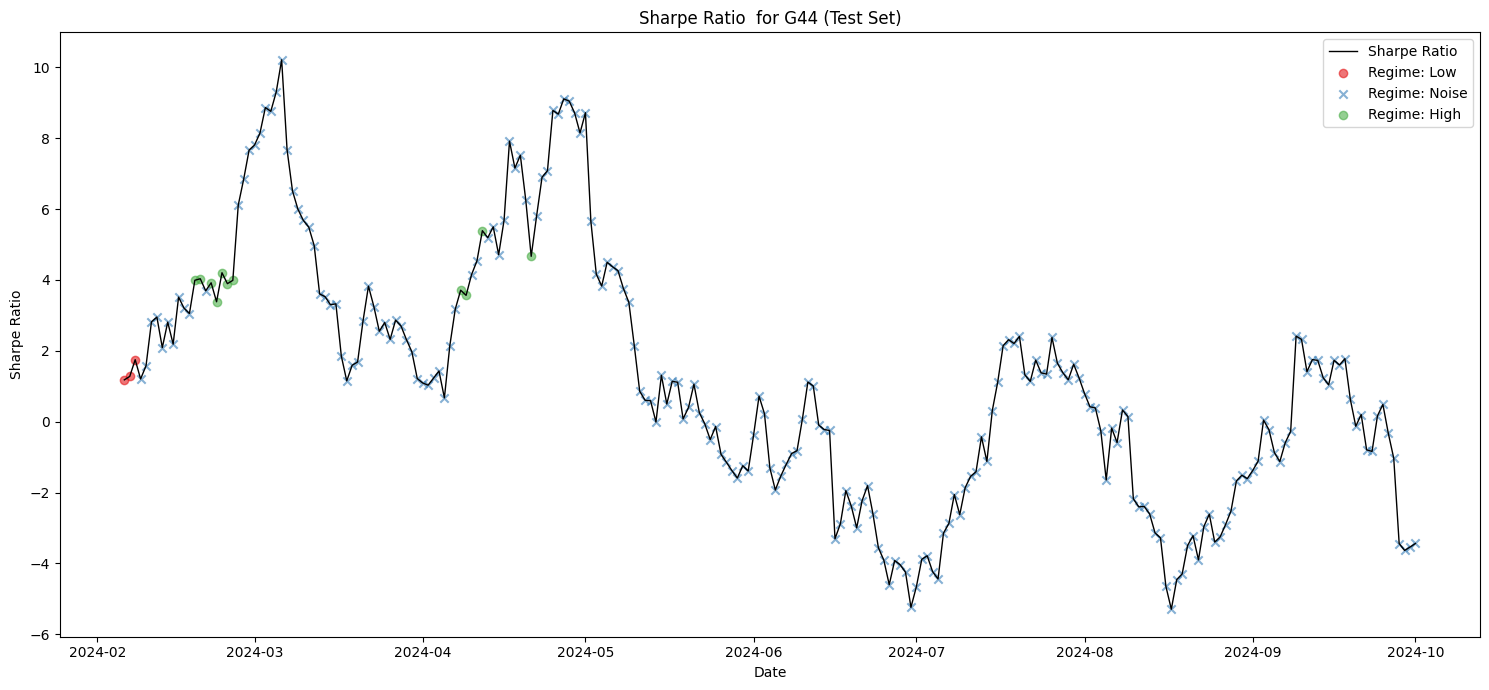

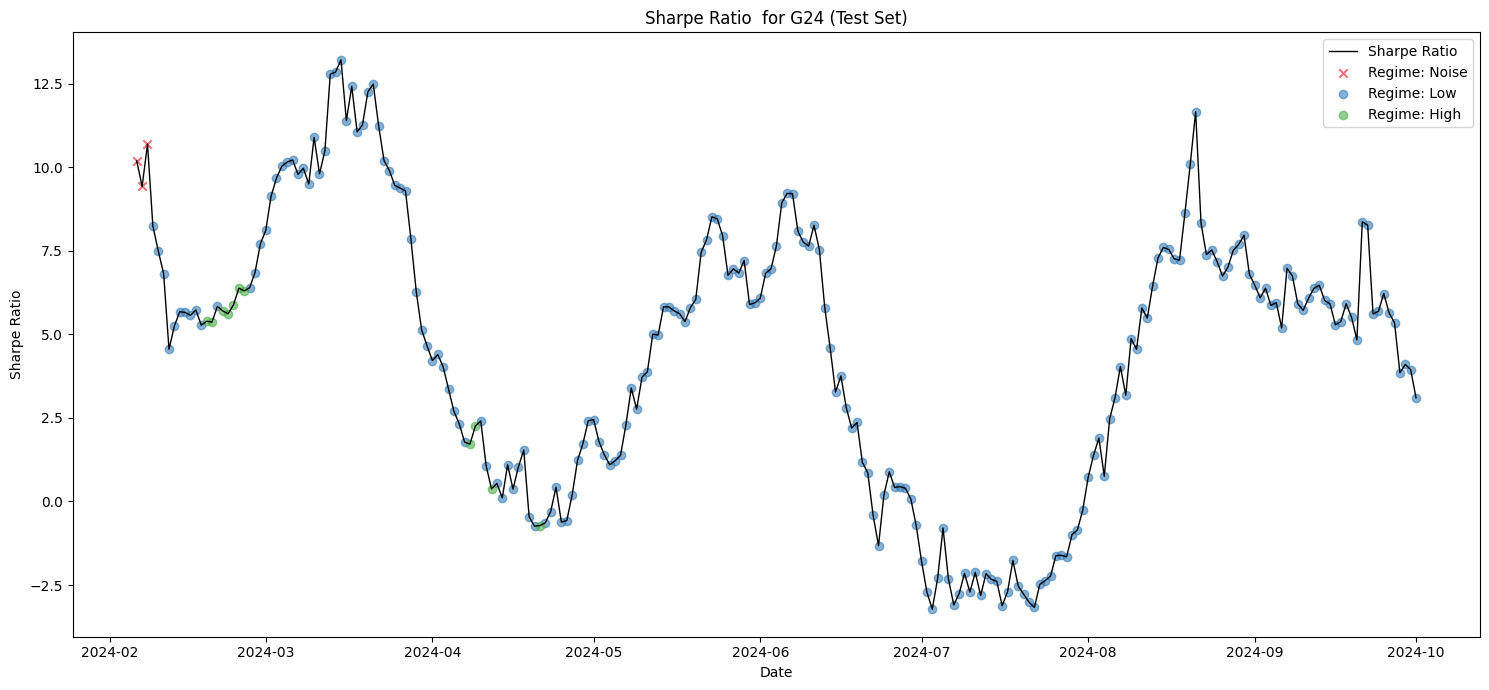

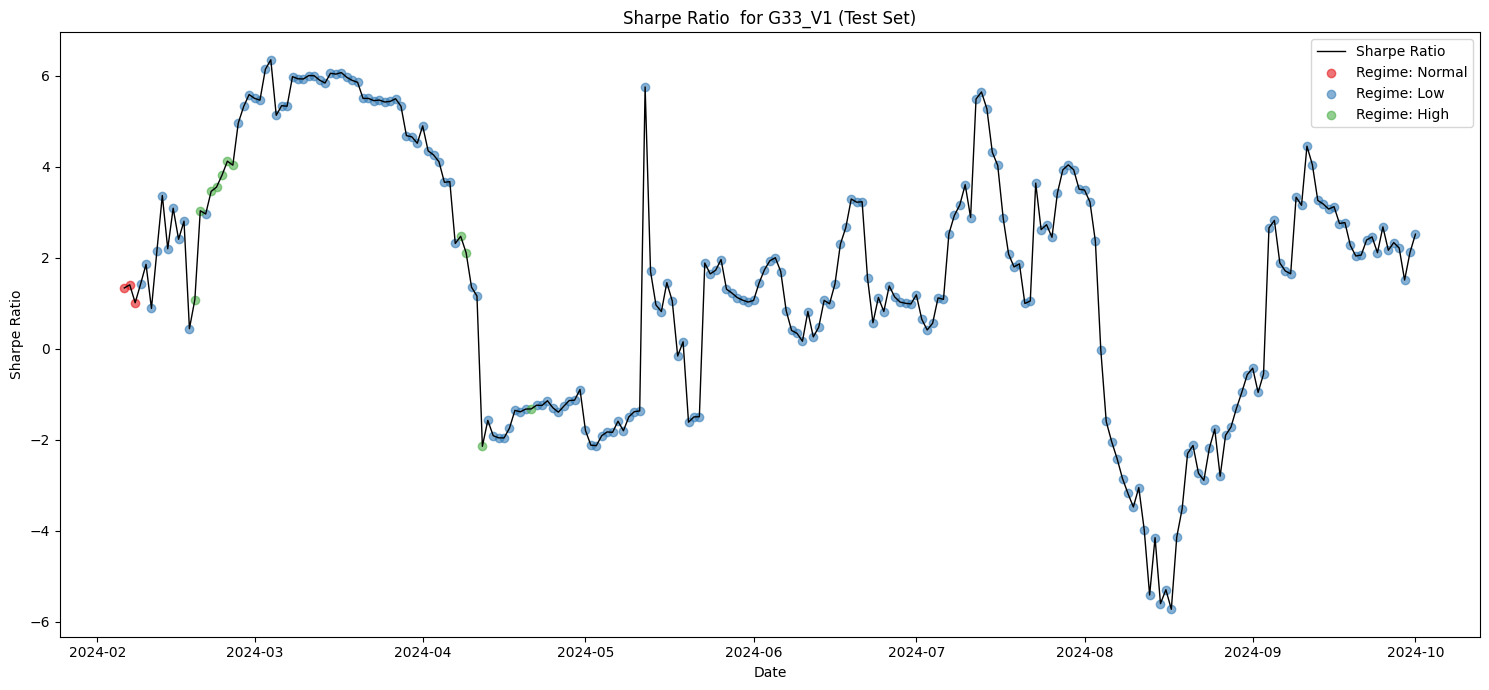

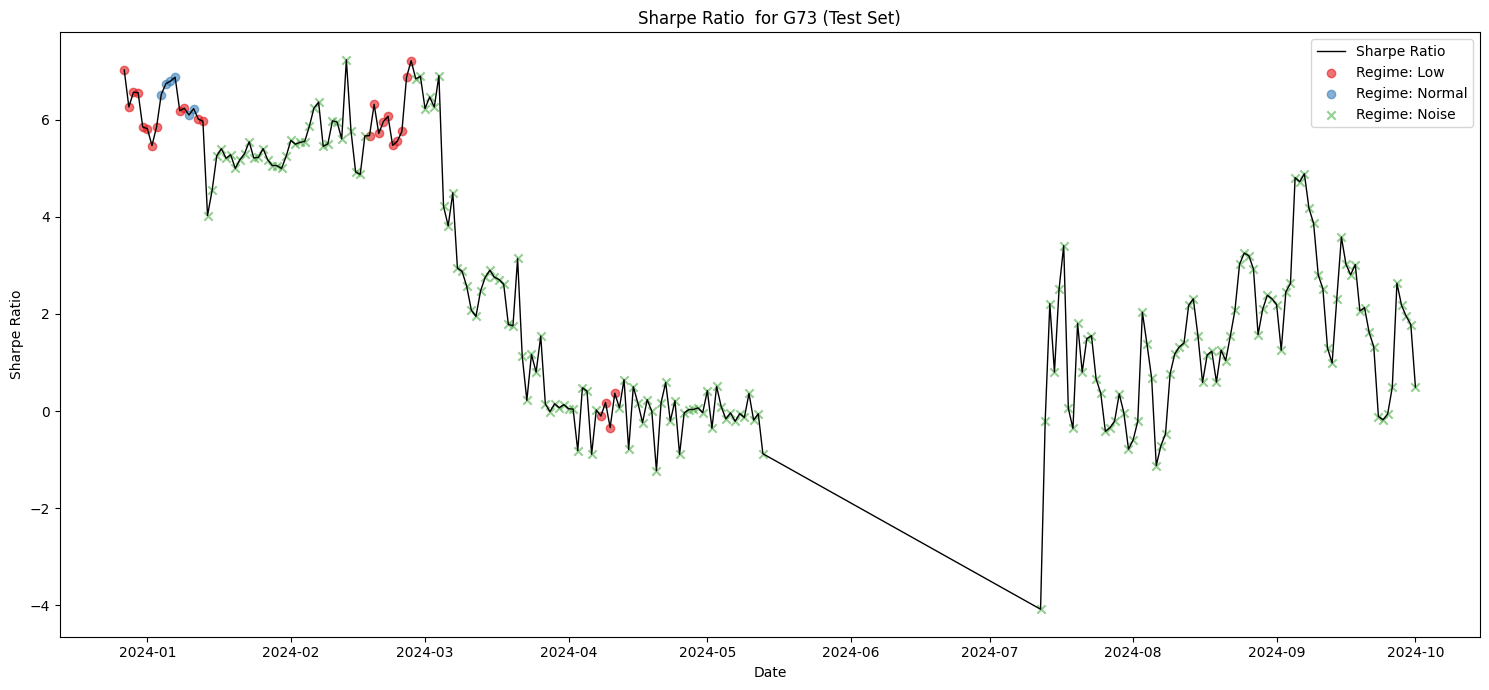

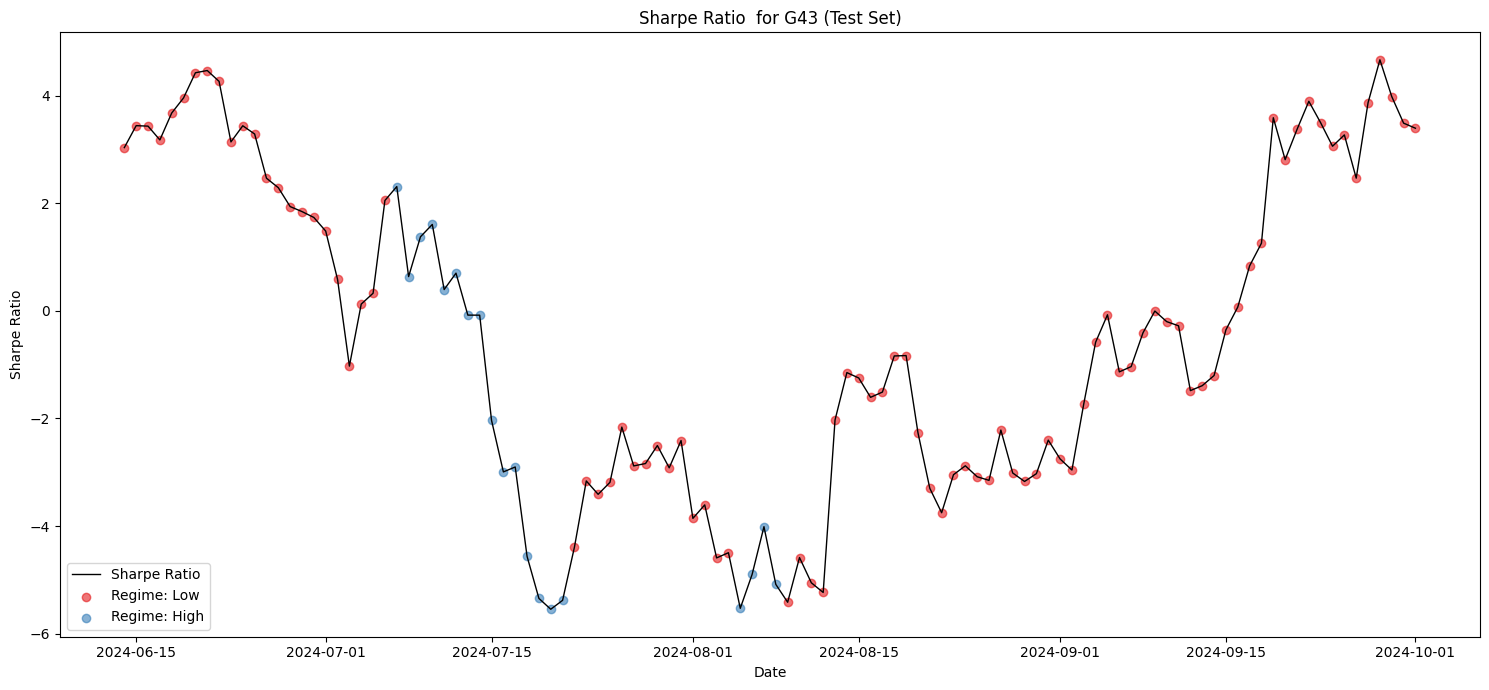

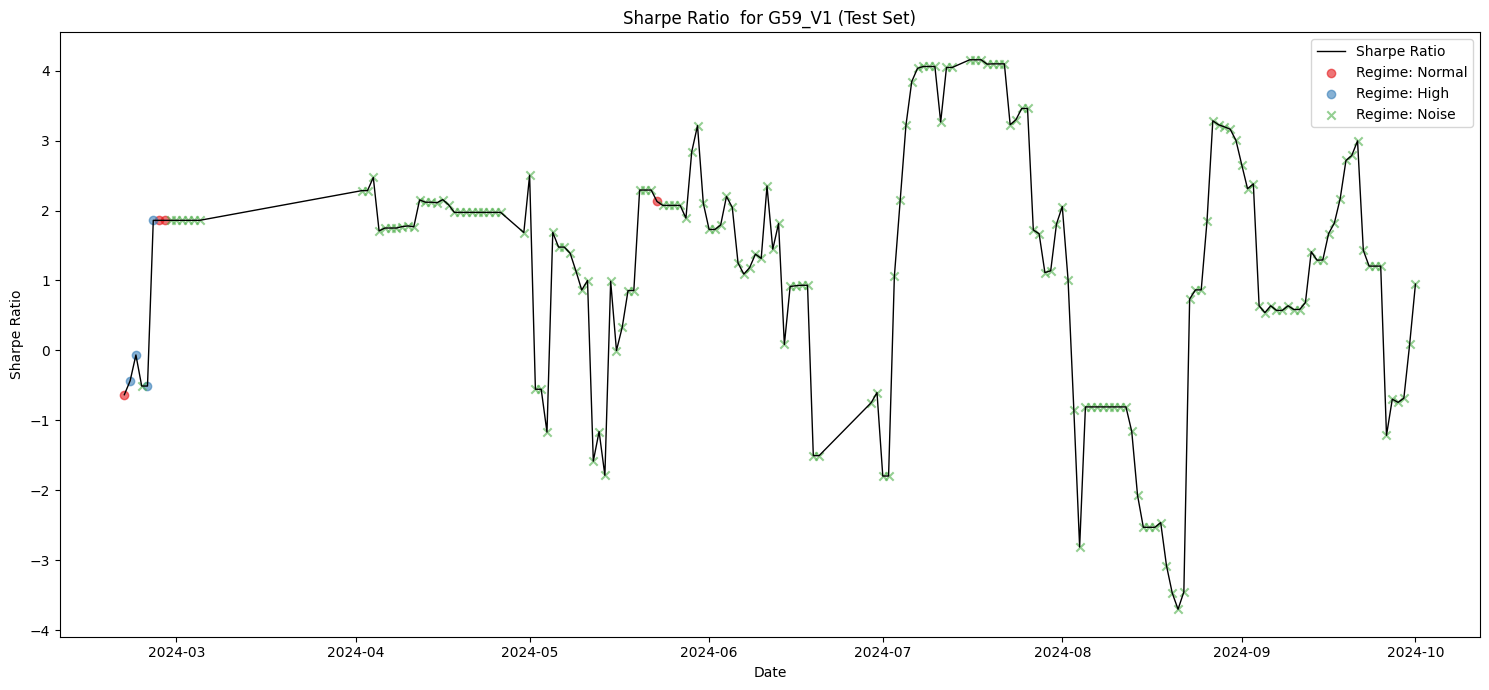

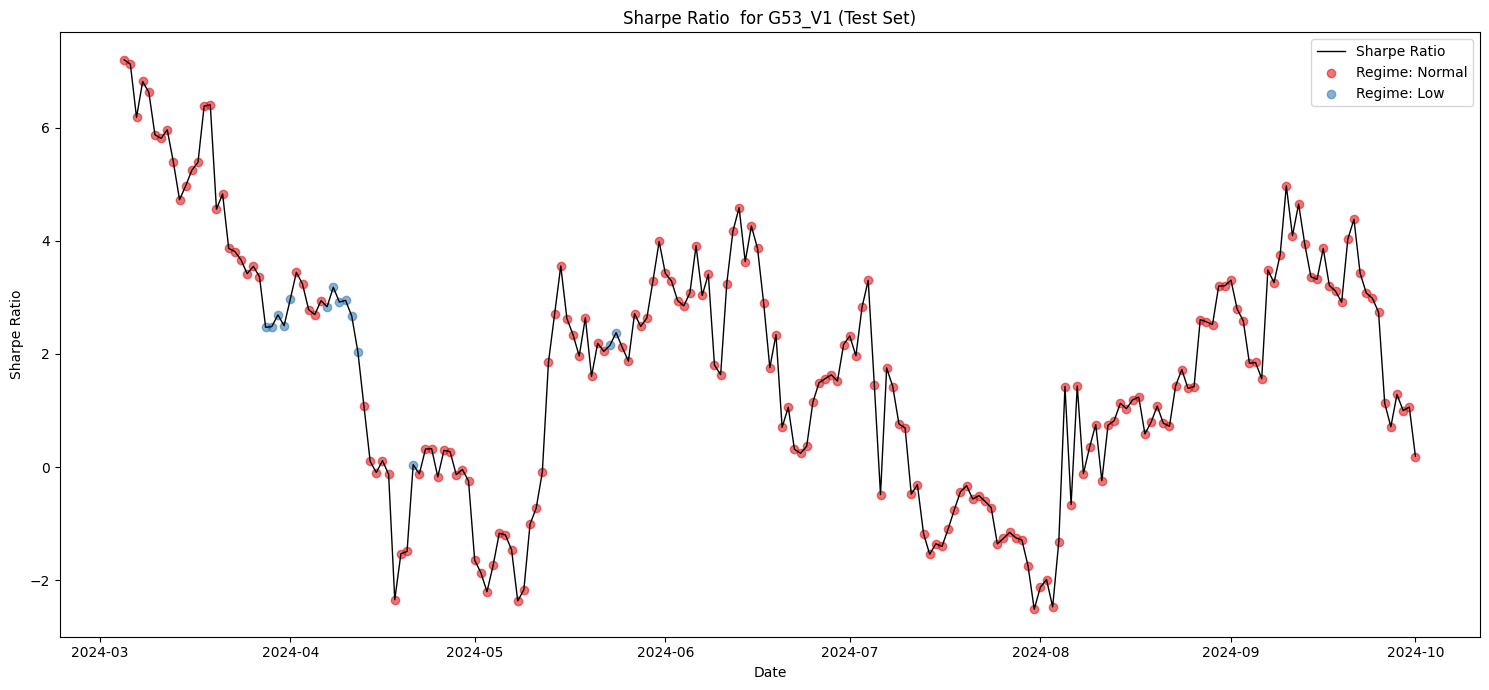

In [59]:
for strategy in test_data.keys():
    df_test = test_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index  
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_30'], label='Sharpe Ratio', color='black', linewidth=1)
    
    unique_regimes = df_test['Regime_Label'].unique()
    palette = sns.color_palette("Set1", len(unique_regimes))
    colors = dict(zip(unique_regimes, palette))
    
    for regime, color in colors.items():
        regime_data = df_test[df_test['Regime_Label'] == regime]
        if regime == 'Noise':
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_30'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='x')
        else:
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_30'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='o')
    
    plt.title(f'Sharpe Ratio  for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"clustering_models/DBSCAN/{strategy}.png")
    plt.show()

In [63]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

train_data, test_data = split_train_test(merged_data)
train_pca_data, test_pca_data, pca_models = apply_pca(train_data, test_data, variance_threshold=0.99)

def fit_gmm(train_pca_data, test_pca_data, n_components=3, covariance_type='full'):
    gmm_models = {}
    train_labels = {}
    test_labels = {}
    
    for strategy in train_pca_data.keys():
        X_train = train_pca_data[strategy].drop(columns=['Sharpe_Ratio_30']).values
        X_test = test_pca_data[strategy].drop(columns=['Sharpe_Ratio_30']).values
        
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        
        gmm.fit(X_train)
        
        train_labels[strategy] = gmm.predict(X_train)
        
        test_labels[strategy] = gmm.predict(X_test)
        
        gmm_models[strategy] = gmm
        
    return gmm_models, train_labels, test_labels

gmm_models, gmm_train_labels, gmm_test_labels = fit_gmm(train_pca_data, test_pca_data, n_components=3, covariance_type='full')


In [64]:
def map_gmm_clusters_to_regimes(train_pca_data, train_labels, test_labels, regime_labels=['Low', 'Normal', 'High']):
    train_regime_labels = {}
    test_regime_labels = {}
    
    for strategy in train_pca_data.keys():
        df_train = train_pca_data[strategy].copy()
        labels = train_labels[strategy]
        df_train['Cluster'] = labels
        
        cluster_sharpe = df_train.groupby('Cluster')['Sharpe_Ratio_30'].mean()
        
        sorted_clusters = cluster_sharpe.sort_values().index.tolist()
        regime_mapping = {}
        if len(sorted_clusters) >= len(regime_labels):
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters[:len(regime_labels)], regime_labels)}
            for cluster in sorted_clusters[len(regime_labels):]:
                regime_mapping[cluster] = f'Label_{cluster}'
        else:
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters, regime_labels[:len(sorted_clusters)])}
        
        df_train['Regime_Label'] = df_train['Cluster'].map(regime_mapping)
        train_regime_labels[strategy] = df_train['Regime_Label']
        
        labels_test = test_labels[strategy]
        df_test = test_pca_data[strategy]
        
        regime_label_test = []
        for lbl in labels_test:
            regime = regime_mapping.get(lbl, 'Noise')  # 'Noise' if label not found
            regime_label_test.append(regime)
        
        test_regime_labels[strategy] = regime_label_test
        
    return train_regime_labels, test_regime_labels

gmm_train_regime_labels, gmm_test_regime_labels = map_gmm_clusters_to_regimes(
    train_pca_data, 
    gmm_train_labels, 
    gmm_test_labels, 
    regime_labels=['Low', 'Normal', 'High']
)

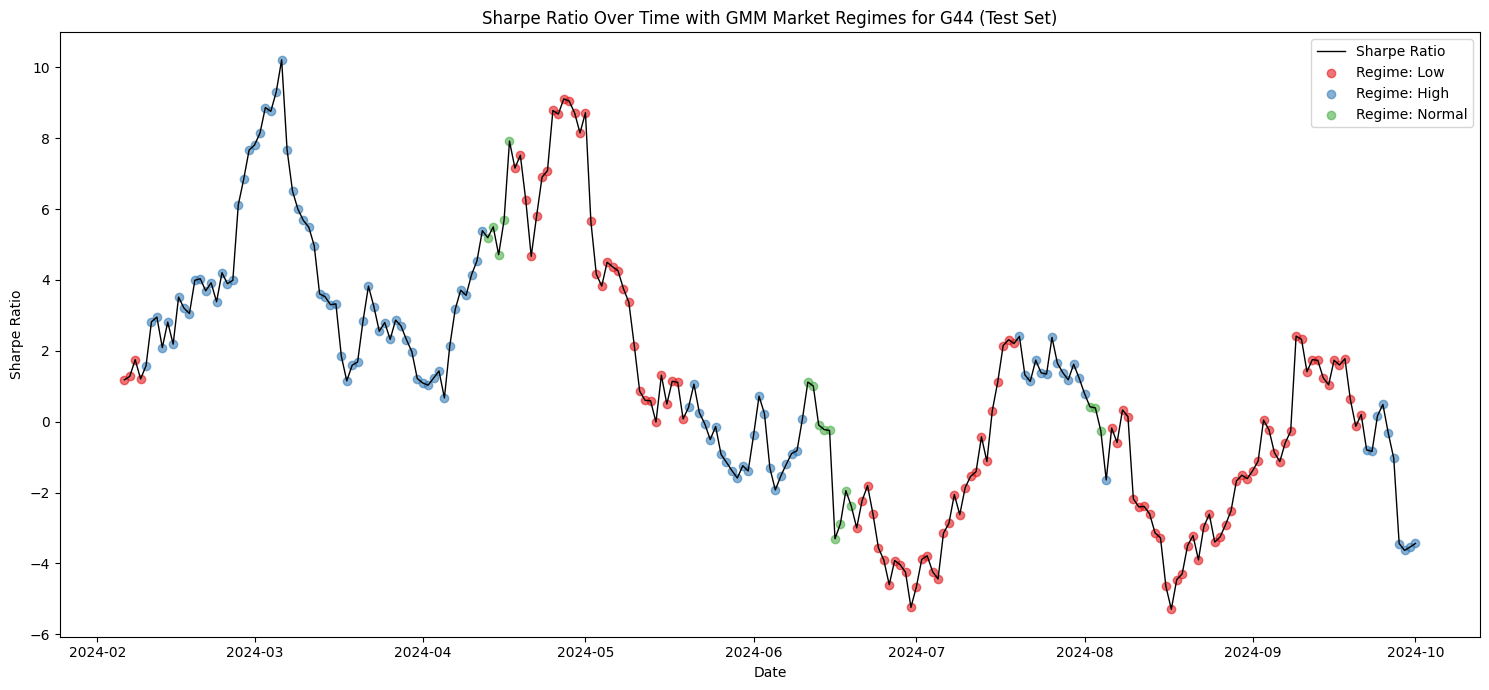

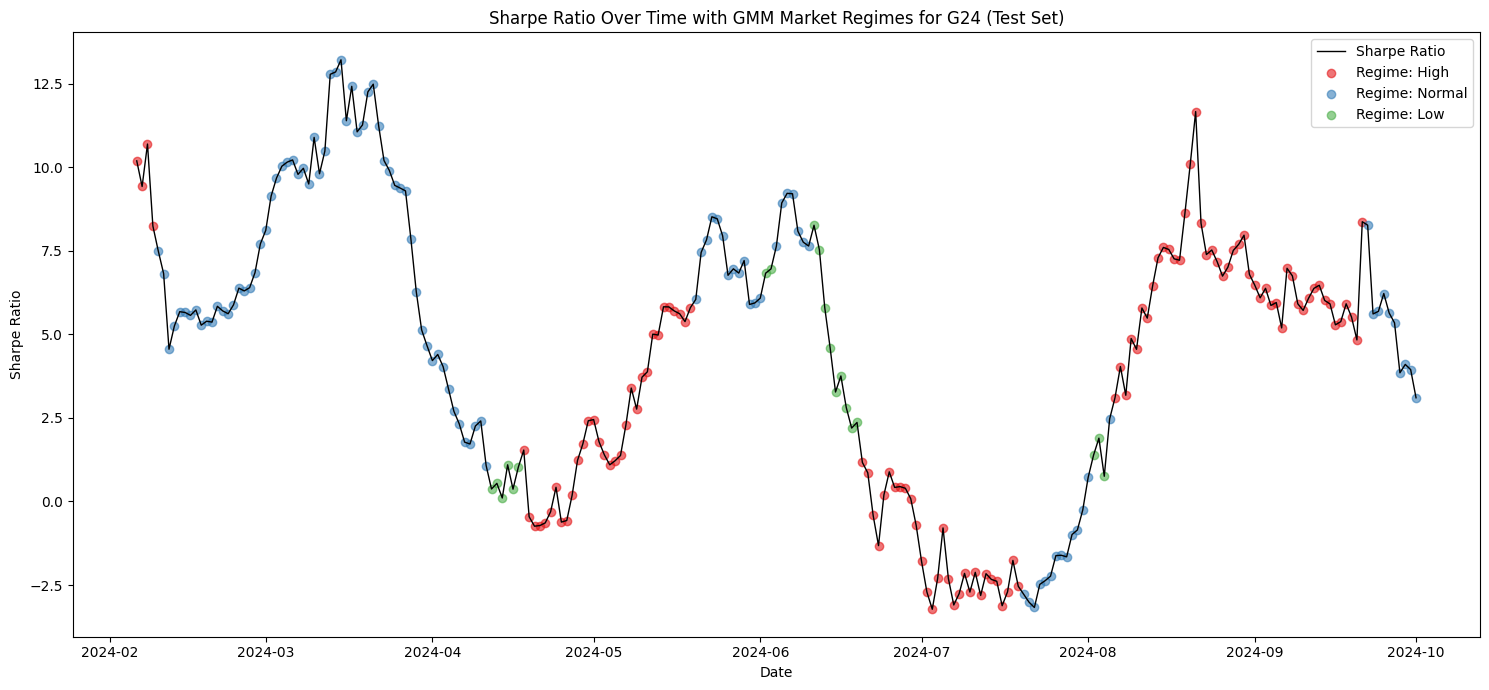

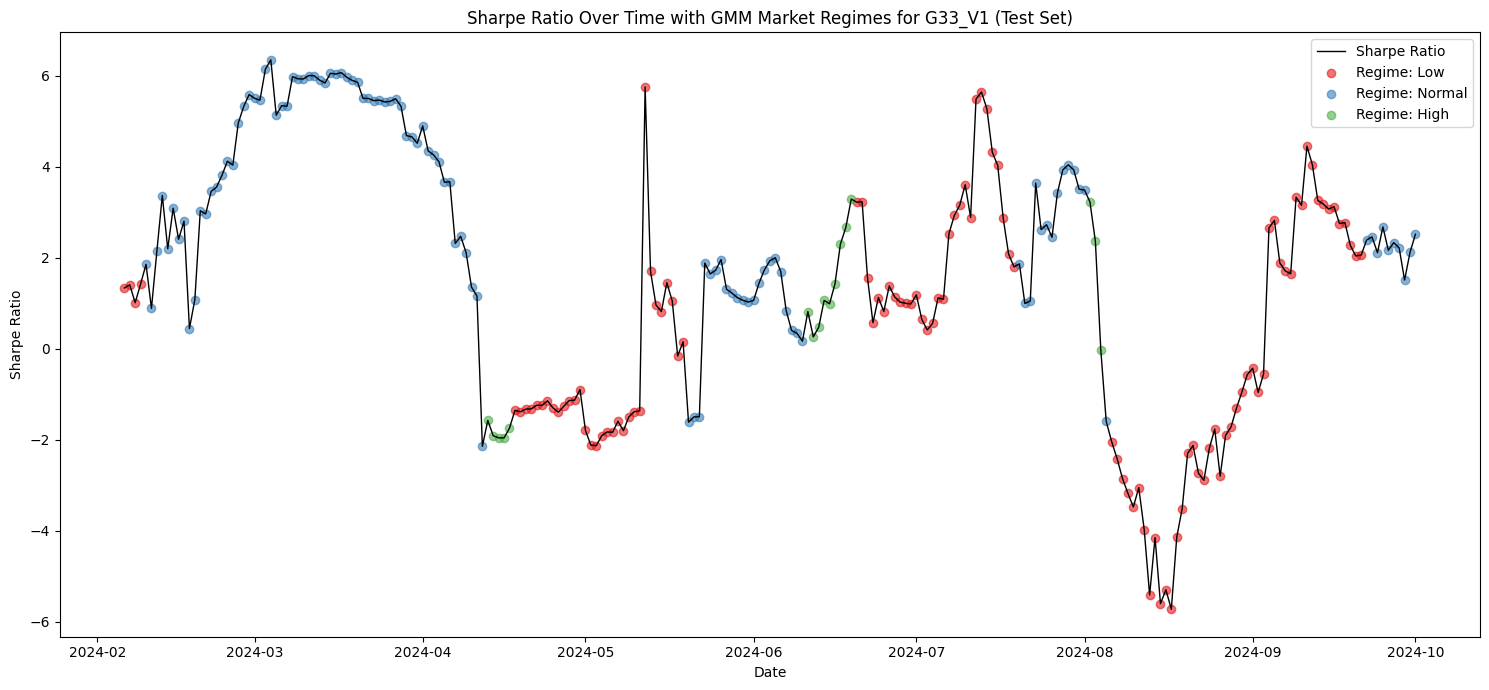

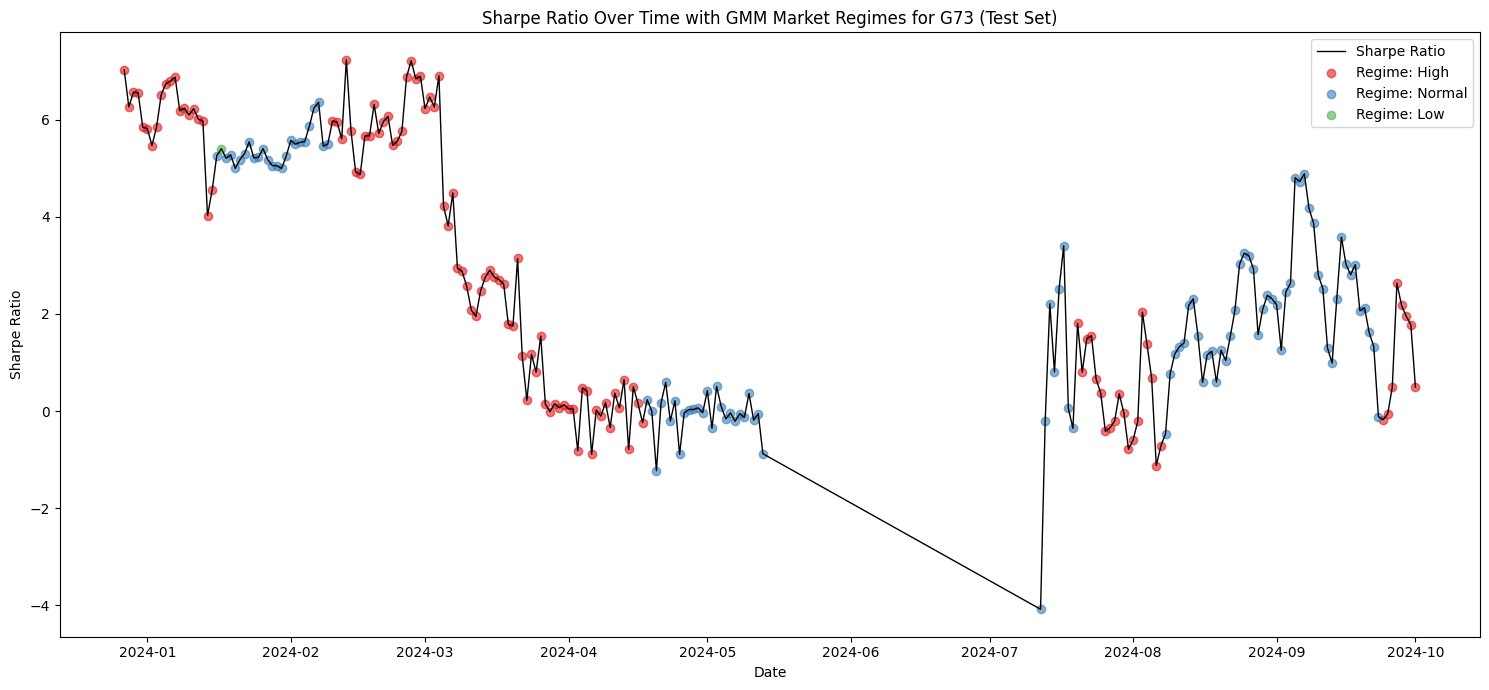

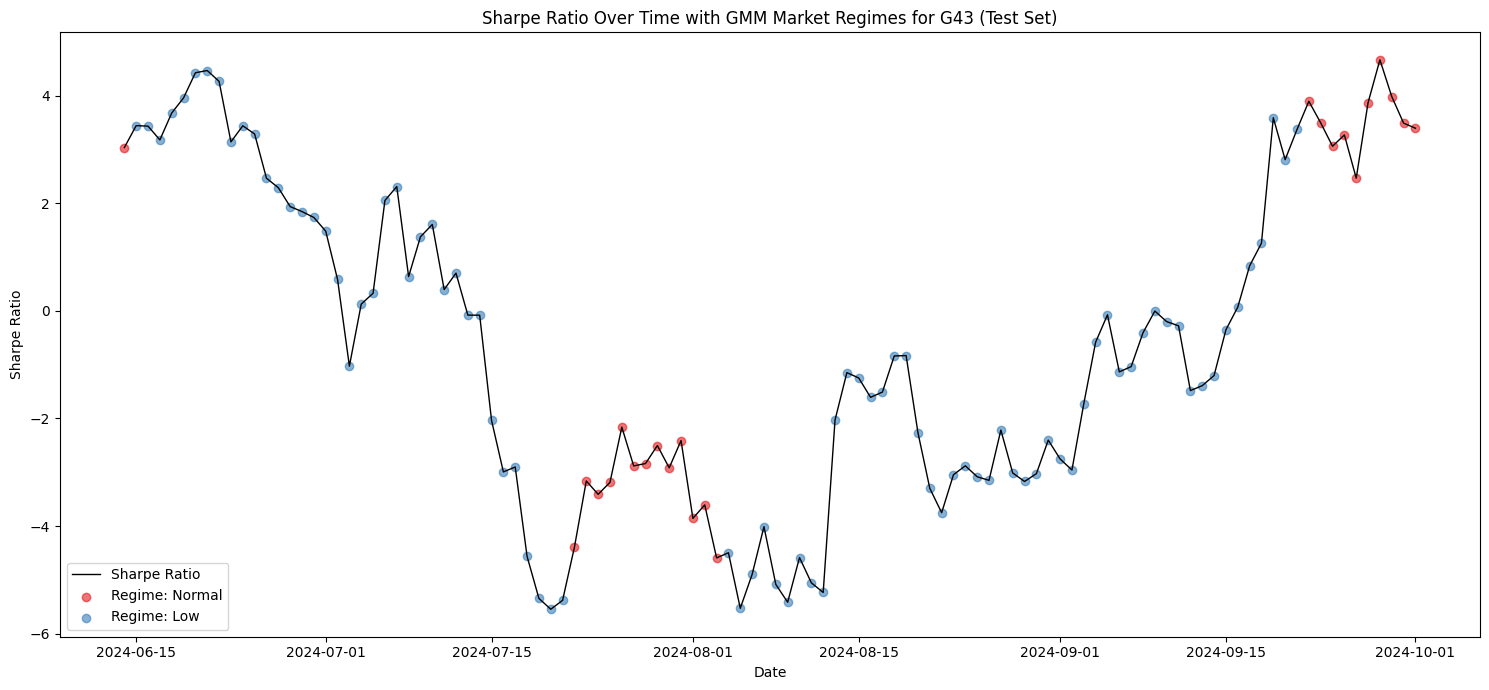

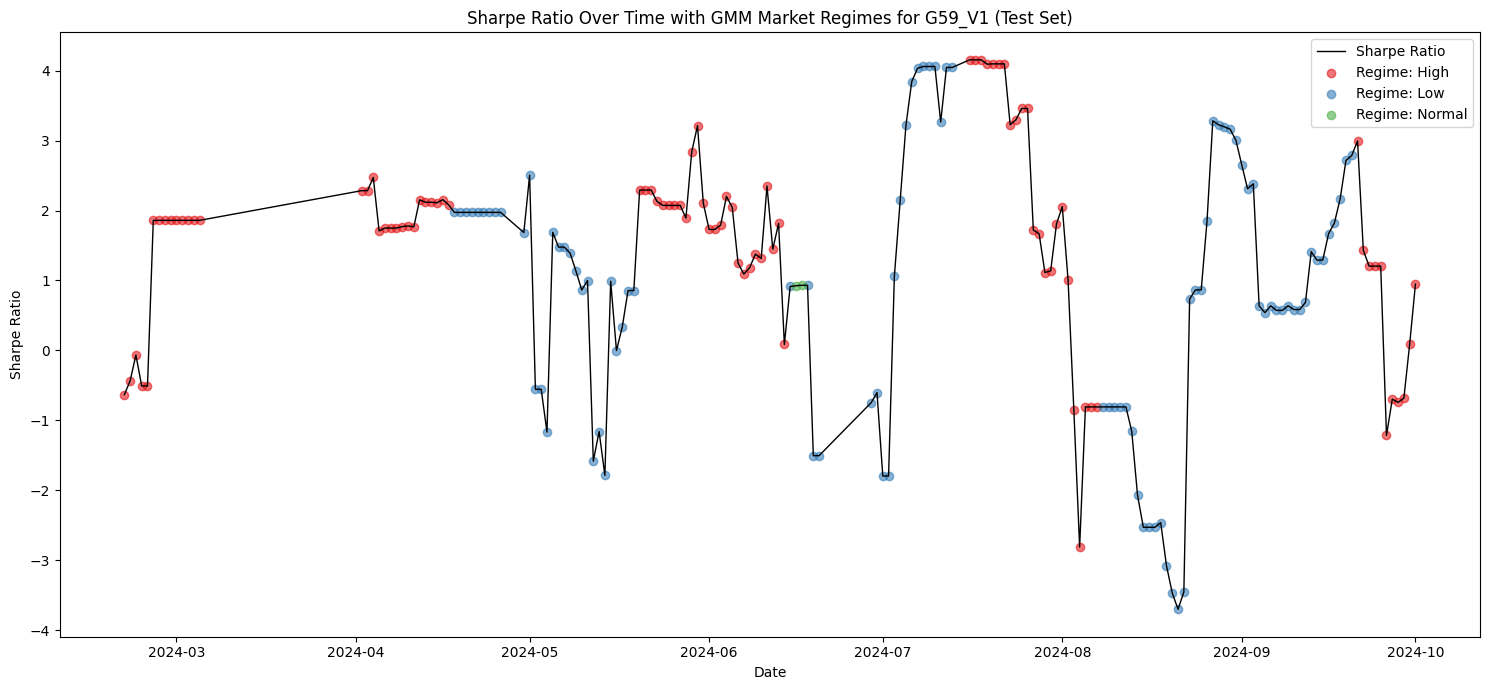

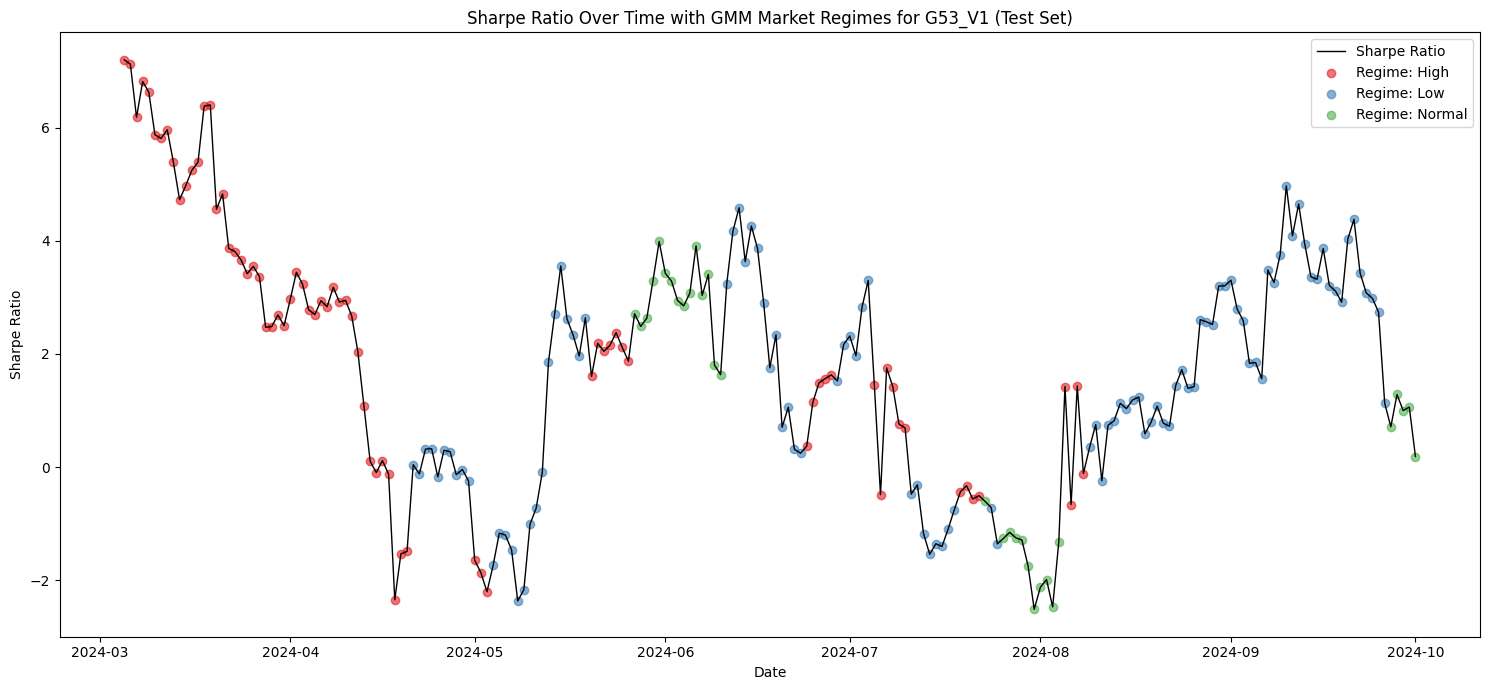

In [65]:
def visualize_gmm_regimes(test_pca_data, test_regime_labels, strategy):
    df_test = test_pca_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index  
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_30'], label='Sharpe Ratio', color='black', linewidth=1)
    
    unique_regimes = df_test['Regime_Label'].unique()
    palette = sns.color_palette("Set1", len(unique_regimes))
    colors = dict(zip(unique_regimes, palette))
    
    for regime, color in colors.items():
        regime_data = df_test[df_test['Regime_Label'] == regime]
        if regime == 'Noise':
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_30'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='x')
        else:
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_30'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='o')
    
    plt.title(f'Sharpe Ratio Over Time with GMM Market Regimes for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"clustering_models/GMM/{strategy}.png")
    plt.show()

for strategy in test_pca_data.keys():
    visualize_gmm_regimes(test_pca_data, gmm_test_regime_labels, strategy)

In [66]:
train_data, test_data = split_train_test(merged_data)
train_pca_data, test_pca_data, pca_models = apply_pca(train_data, test_data, variance_threshold=1)

def fit_agglomerative(train_pca_data, test_pca_data, n_clusters=3, linkage='ward'):
    agg_models = {}
    train_labels = {}
    test_labels = {}
    
    for strategy in train_pca_data.keys():
        X_train = train_pca_data[strategy].drop(columns=['Sharpe_Ratio_30']).values
        X_test = test_pca_data[strategy].drop(columns=['Sharpe_Ratio_30']).values
        
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        
        agg.fit(X_train)
        
        train_labels[strategy] = agg.labels_
        centroids = {}
        for cluster in range(n_clusters):
            centroids[cluster] = X_train[agg.labels_ == cluster].mean(axis=0)
        
        centroids_array = np.array(list(centroids.values()))
        
        neighbors = NearestNeighbors(n_neighbors=1)
        neighbors.fit(centroids_array)
        
        distances, indices = neighbors.kneighbors(X_test)
        assigned_labels = indices.flatten()
        
        test_labels[strategy] = assigned_labels
        
        agg_models[strategy] = agg
        
    return agg_models, train_labels, test_labels

agg_models, agg_train_labels, agg_test_labels = fit_agglomerative(
    train_pca_data, 
    test_pca_data, 
    n_clusters=3, 
    linkage='ward'  
)

In [67]:
def map_agg_clusters_to_regimes(train_pca_data, train_labels, test_labels, regime_labels=['Low', 'Normal', 'High']):
    train_regime_labels = {}
    test_regime_labels = {}
    
    for strategy in train_pca_data.keys():
        df_train = train_pca_data[strategy].copy()
        labels = train_labels[strategy]
        df_train['Cluster'] = labels
        
        cluster_sharpe = df_train.groupby('Cluster')['Sharpe_Ratio_30'].mean()
        
        sorted_clusters = cluster_sharpe.sort_values().index.tolist()
        
        regime_mapping = {}
        if len(sorted_clusters) >= len(regime_labels):
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters[:len(regime_labels)], regime_labels)}
            for cluster in sorted_clusters[len(regime_labels):]:
                regime_mapping[cluster] = f'Label_{cluster}'
        else:
            regime_mapping = {cluster: label for cluster, label in zip(sorted_clusters, regime_labels[:len(sorted_clusters)])}
        
        df_train['Regime_Label'] = df_train['Cluster'].map(regime_mapping)
        train_regime_labels[strategy] = df_train['Regime_Label']
        
        labels_test = test_labels[strategy]
        df_test = test_pca_data[strategy]
        
        regime_label_test = []
        for lbl in labels_test:
            regime = regime_mapping.get(lbl, 'Noise')  #  'Noise' if label not found
            regime_label_test.append(regime)
        
        test_regime_labels[strategy] = regime_label_test
        
    return train_regime_labels, test_regime_labels

agg_train_regime_labels, agg_test_regime_labels = map_agg_clusters_to_regimes(
    train_pca_data, 
    agg_train_labels, 
    agg_test_labels, 
    regime_labels=['Low', 'Normal', 'High']
)


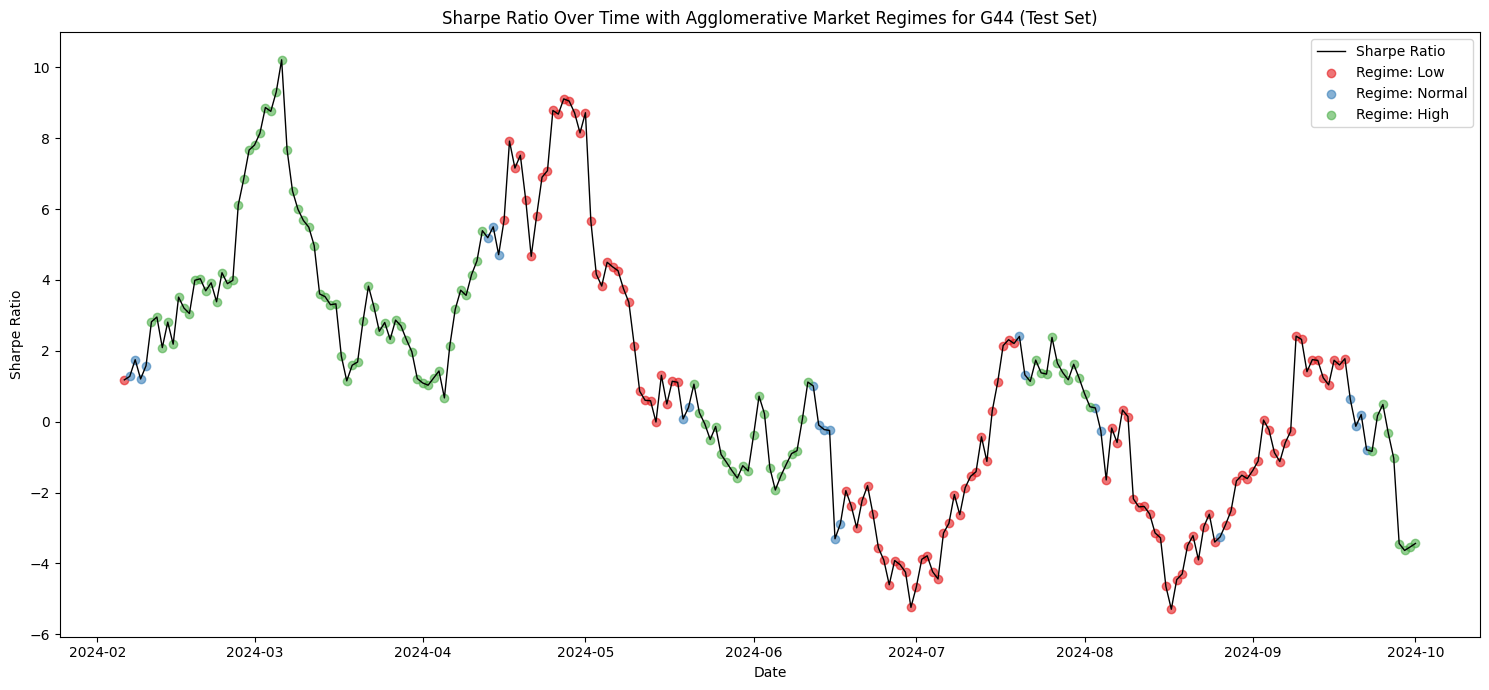

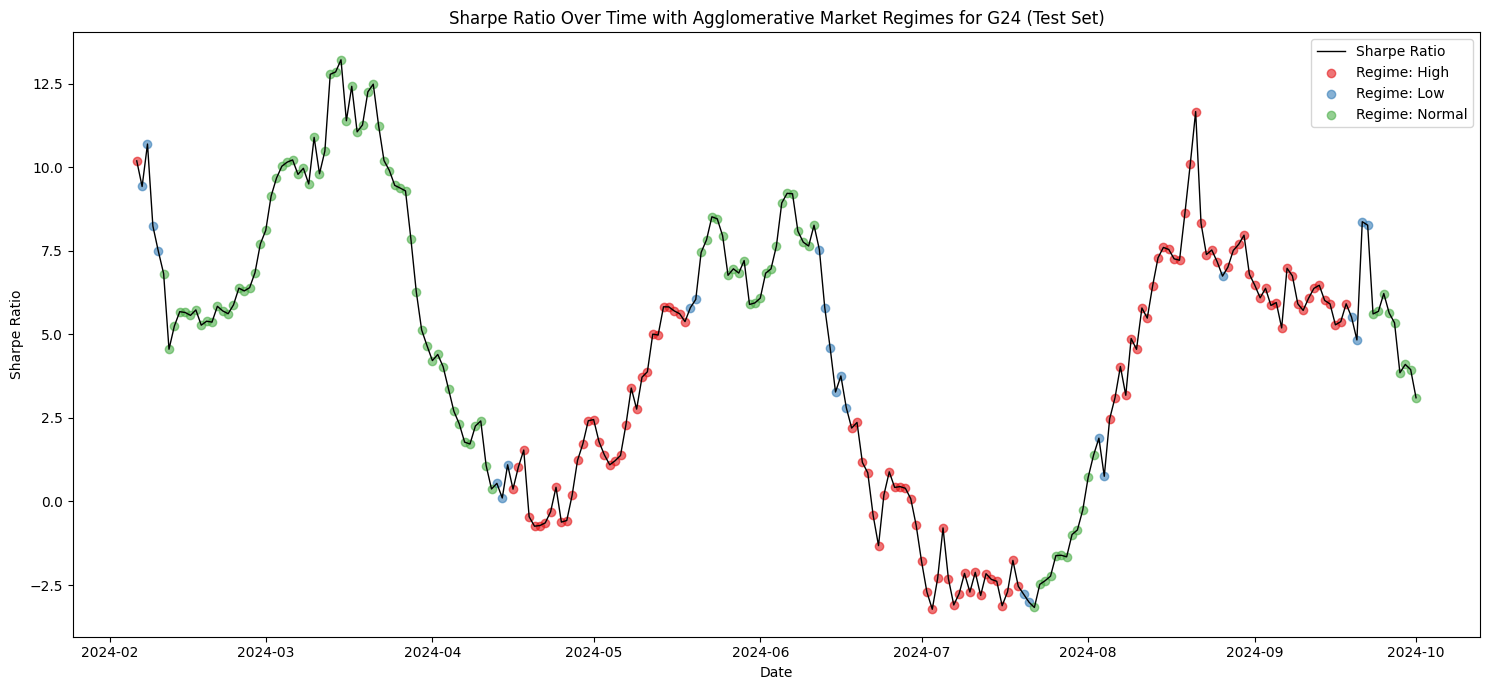

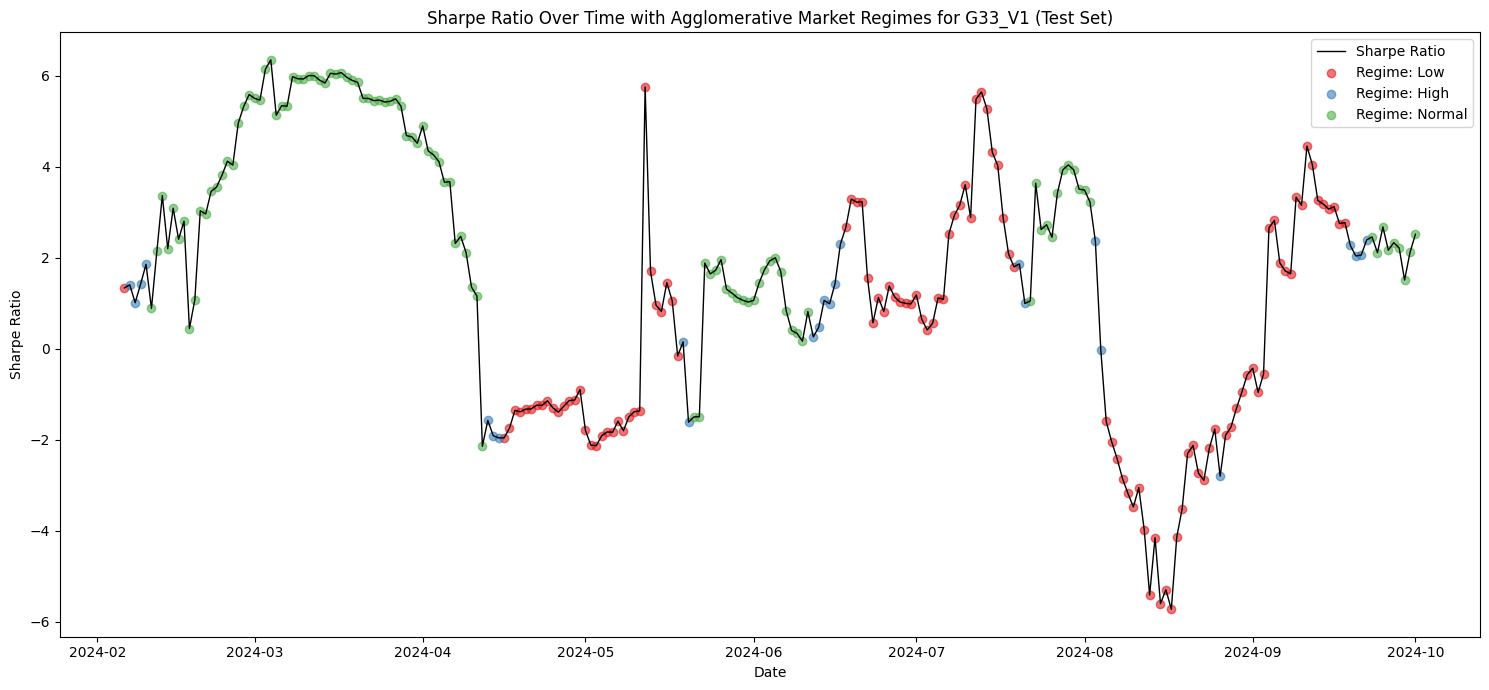

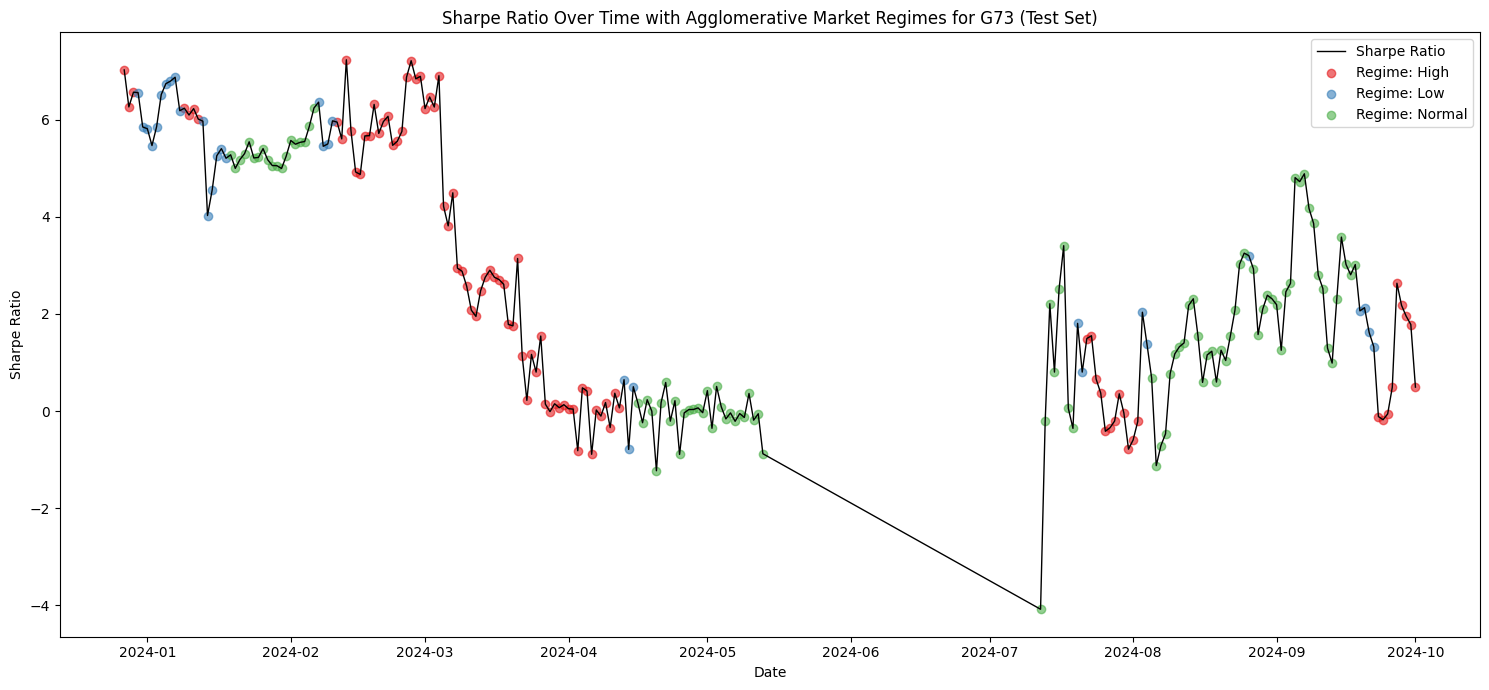

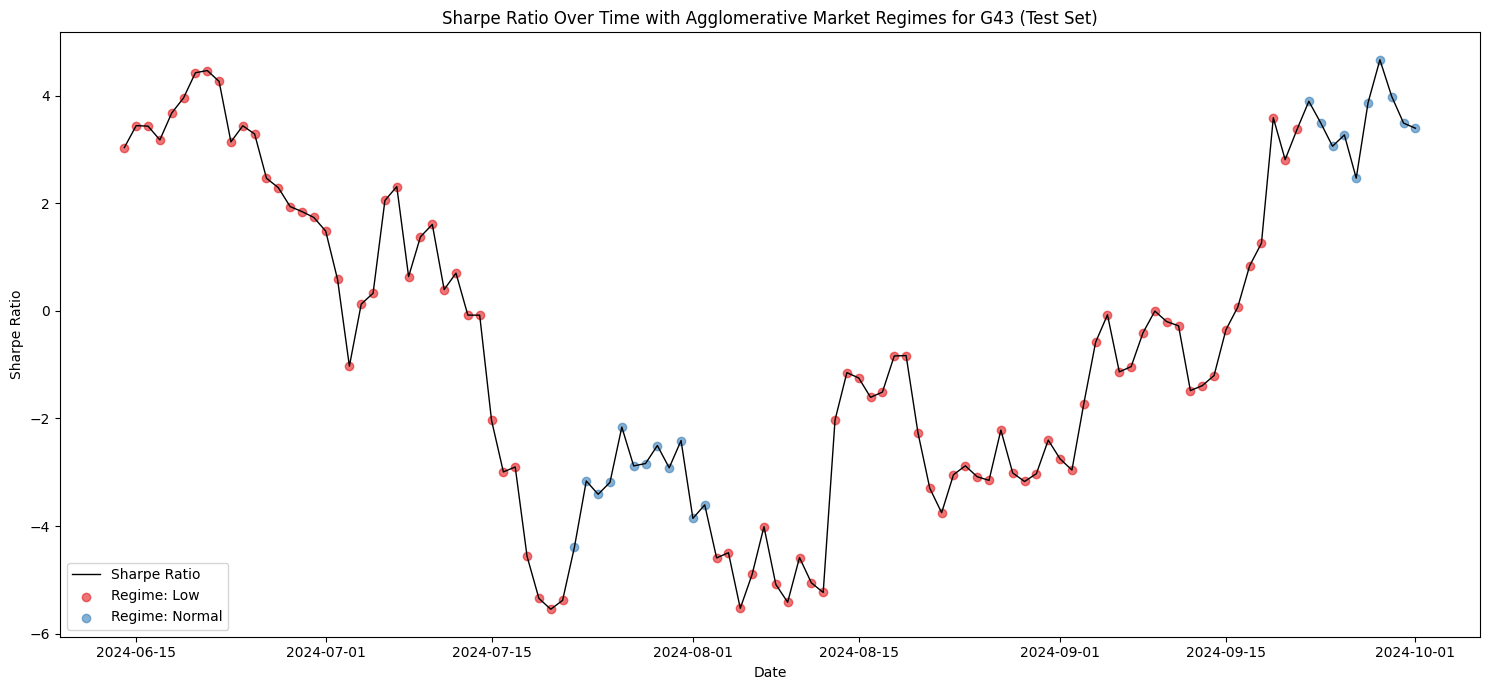

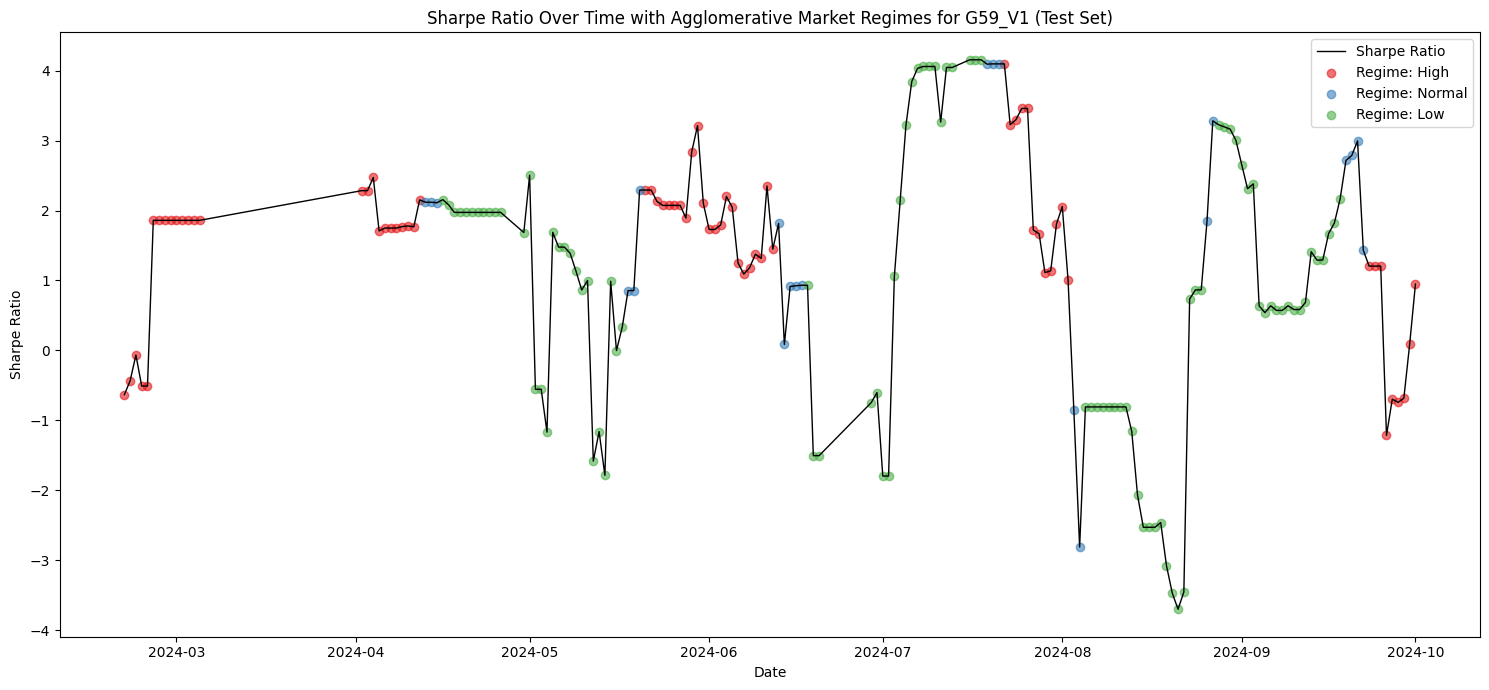

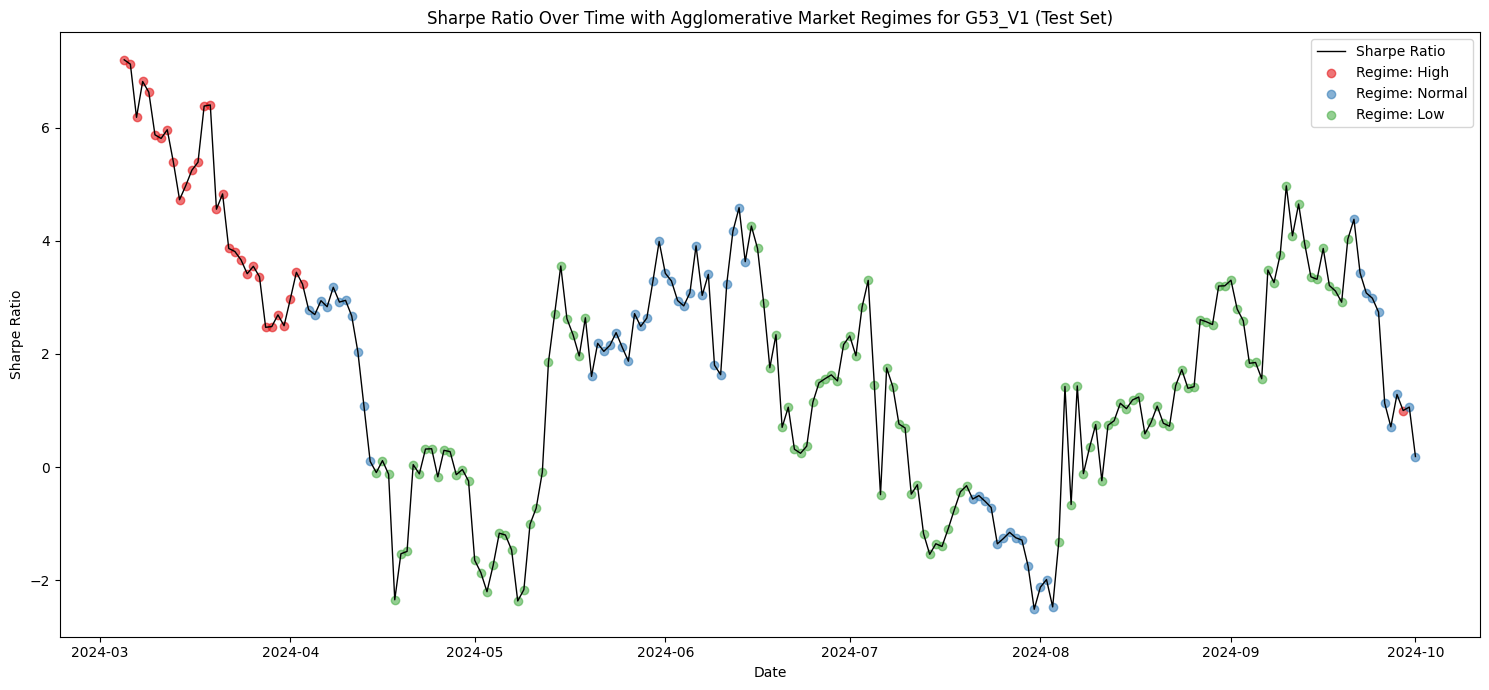

In [68]:
def visualize_agg_regimes(test_pca_data, test_regime_labels, strategy):
    df_test = test_pca_data[strategy].copy()
    df_test['Regime_Label'] = test_regime_labels[strategy]
    df_test['datetime'] = df_test.index 
    
    plt.figure(figsize=(15,7))
    
    plt.plot(df_test['datetime'], df_test['Sharpe_Ratio_30'], label='Sharpe Ratio', color='black', linewidth=1)
    
    unique_regimes = df_test['Regime_Label'].unique()
    palette = sns.color_palette("Set1", len(unique_regimes))
    colors = dict(zip(unique_regimes, palette))
    
    for regime, color in colors.items():
        regime_data = df_test[df_test['Regime_Label'] == regime]
        if regime == 'Noise':
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_30'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='x')
        else:
            plt.scatter(regime_data['datetime'], regime_data['Sharpe_Ratio_30'], 
                        color=color, label=f'Regime: {regime}', alpha=0.6, marker='o')
    
    plt.title(f'Sharpe Ratio Over Time with Agglomerative Market Regimes for {strategy} (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"clustering_models/AHC/{strategy}.png")
    plt.show()

for strategy in test_pca_data.keys():
    visualize_agg_regimes(test_pca_data, agg_test_regime_labels, strategy)
